  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

Loading Data


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.53it/s]


Return on investment total  : 2.34%
Return on investment at sale: 1.64%


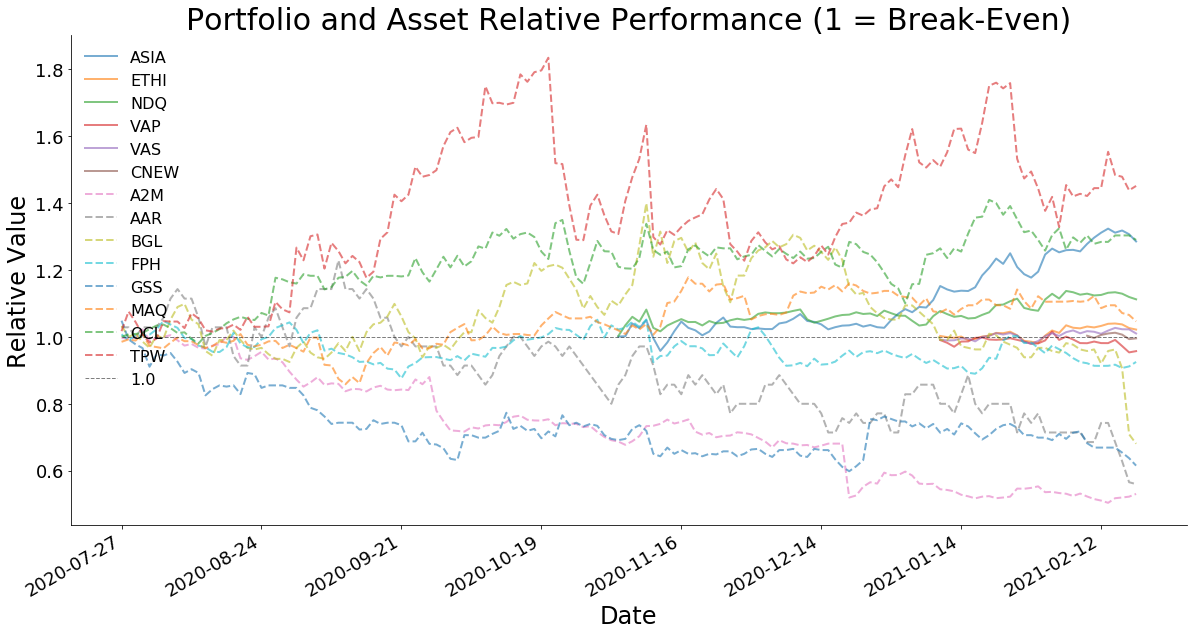

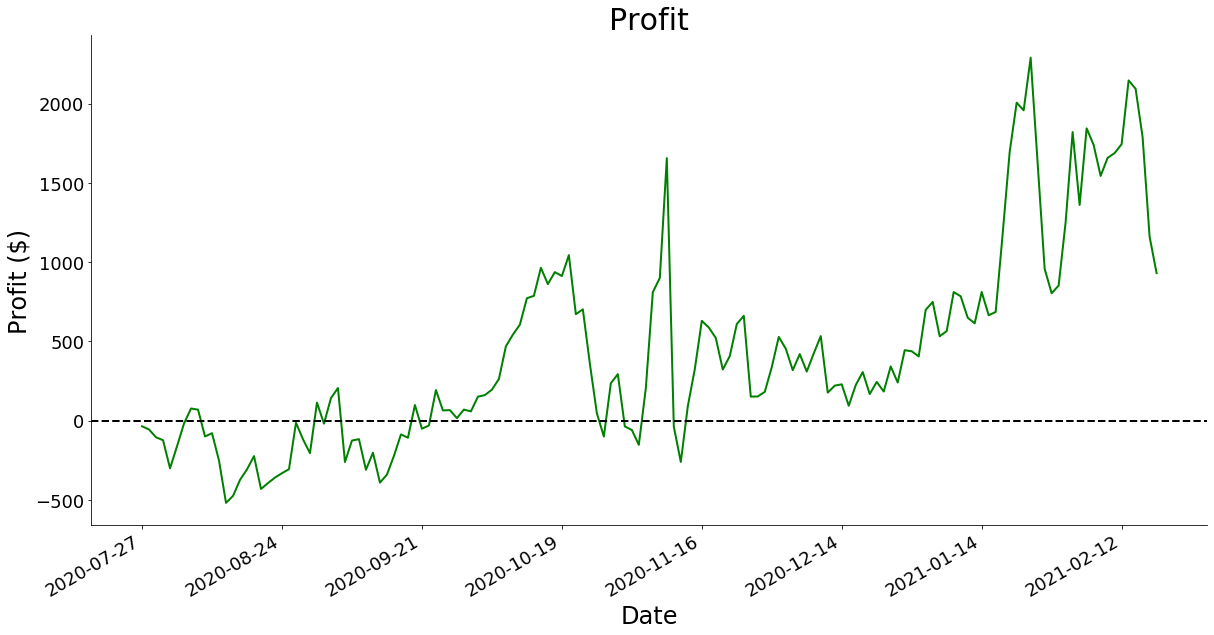

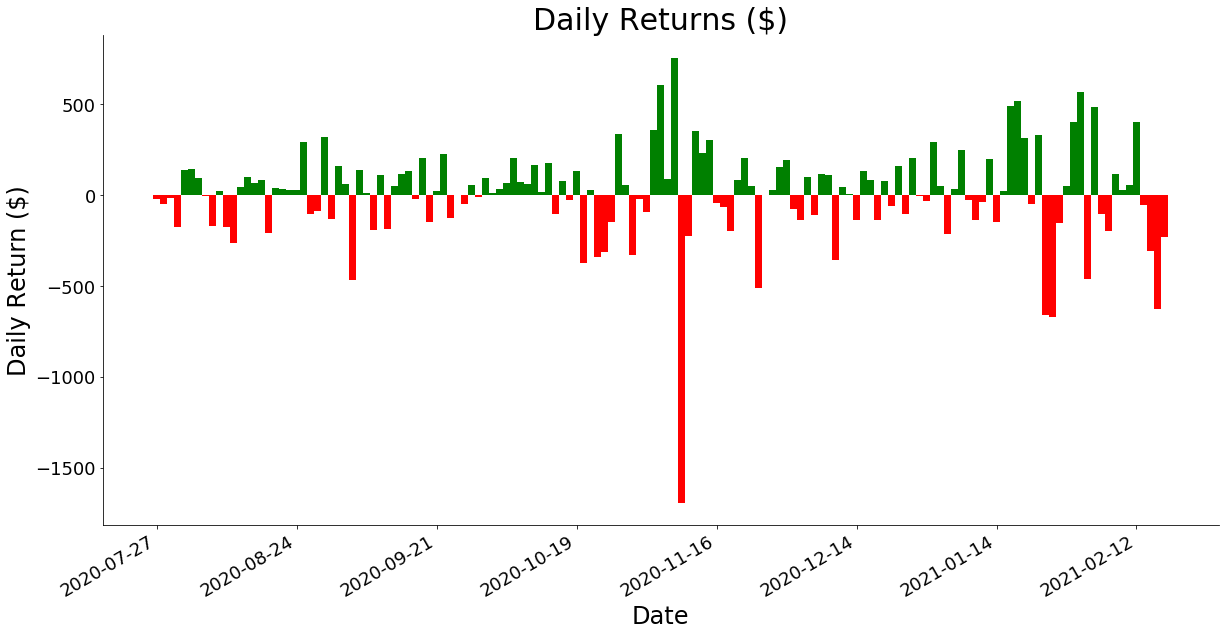

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from stock_utils_updated import equidate_ax, load_data, plot_shares, plot_profit, plot_returns

SMALL, MED, LARGE, LW = 18, 24, 30, 2
plt.rc('xtick',labelsize=SMALL)
plt.rc('ytick',labelsize=SMALL)

TOMORROW = str(dt.datetime.today().date() + dt.timedelta(days=1))
TRADING_DAYS = 252
TRADING_FEE = 19.95
fee_adjusted = lambda units, price: (units*price + TRADING_FEE) / units

UNITS, PRICE, BUY_DATE, SELL_DATE, FEE_ADJUSTED_PRICE = 0, 1, 2, 3, 4
#          CODE: [Unit,  Price,      BuyDate, SellDate, Fee-Adjusted Price]
SHARES = {'A2M': [  61, 19.500, '2020-07-27', TOMORROW], 'AAR': [4244,  0.175, '2020-07-27', TOMORROW],
          'ASIA':[ 465, 10.730, '2020-11-03', TOMORROW], 'BGL': [ 868,  1.065, '2020-07-27', TOMORROW],
          'ETHI':[ 453, 11.010, '2021-01-11', TOMORROW], 'FPH': [  60, 32.850, '2020-07-27', TOMORROW],
          'GSS': [ 404,  2.690, '2020-07-27', TOMORROW], 'MAQ': [  25, 46.600, '2020-07-27', TOMORROW],
          'OCL': [  96, 10.360, '2020-07-27', TOMORROW], 'TPW': [ 205,  7.650, '2020-07-27', TOMORROW], 
          'NDQ': [ 192, 26.030, '2020-11-03', TOMORROW], 'VAP': [  62, 80.630, '2021-01-11', TOMORROW],
          'VAS': [  58, 86.120, '2021-01-11', TOMORROW], 'CNEW':[ 559,  8.890, '2021-02-10', TOMORROW]}
ETFS = ['ASIA', 'ETHI', 'NDQ', 'VAP', 'VAS', 'CNEW']

for code, info in SHARES.items():
    units, price, buy_date, sell_date = info
    SHARES[code].append(fee_adjusted(units, price))
    SHARES[code][BUY_DATE]  = pd.to_datetime(buy_date)
    SHARES[code][SELL_DATE] = pd.to_datetime(sell_date)
TOMORROW = pd.to_datetime(TOMORROW)

INITIAL_VALUE = sum(v[UNITS]*v[PRICE]              for k, v in SHARES.items())
INITIAL_COST  = sum(v[UNITS]*v[FEE_ADJUSTED_PRICE] for k, v in SHARES.items())

daily = load_data(SHARES.keys())

# Place zeros where share was not held
for i, code in enumerate(daily):
    _, _, buy_date, sell_date, _ = SHARES[code]
    daily.iloc[0:daily.index.to_list().index(buy_date), i] = 0
    if sell_date != TOMORROW:
        daily.iloc[daily.index.to_list().index(sell_date):, i] = 0

UNITS = np.array([SHARES[code][UNITS] for code in daily])
PORTFOLIO_VALUE = daily.to_numpy() @ UNITS

INITIAL_COSTS = []
for date, row in daily.iterrows():
    INITIAL_COSTS.append(0)
    for code, info in SHARES.items():
        units, _, buy_date, sell_date, fee_adjusted_price = info
        if buy_date <= date <= sell_date:
            INITIAL_COSTS[-1] += units * fee_adjusted_price
PROFIT = PORTFOLIO_VALUE - np.array(INITIAL_COSTS)

# Output
print(f'Return on investment total  : {round(100 * (PORTFOLIO_VALUE[-1] / (INITIAL_COST) - 1), 2)}%')
print('Return on investment at sale: ' +
      f'{round(100 * ((PORTFOLIO_VALUE[-1] - TRADING_FEE*len(SHARES)) / (INITIAL_COST) - 1), 2)}%')
plot_shares(daily, PORTFOLIO_VALUE, SHARES, INITIAL_COST, ETFS)
plot_profit(daily, PROFIT)
plot_returns(daily, PROFIT)

NameError: name 'profits' is not defined

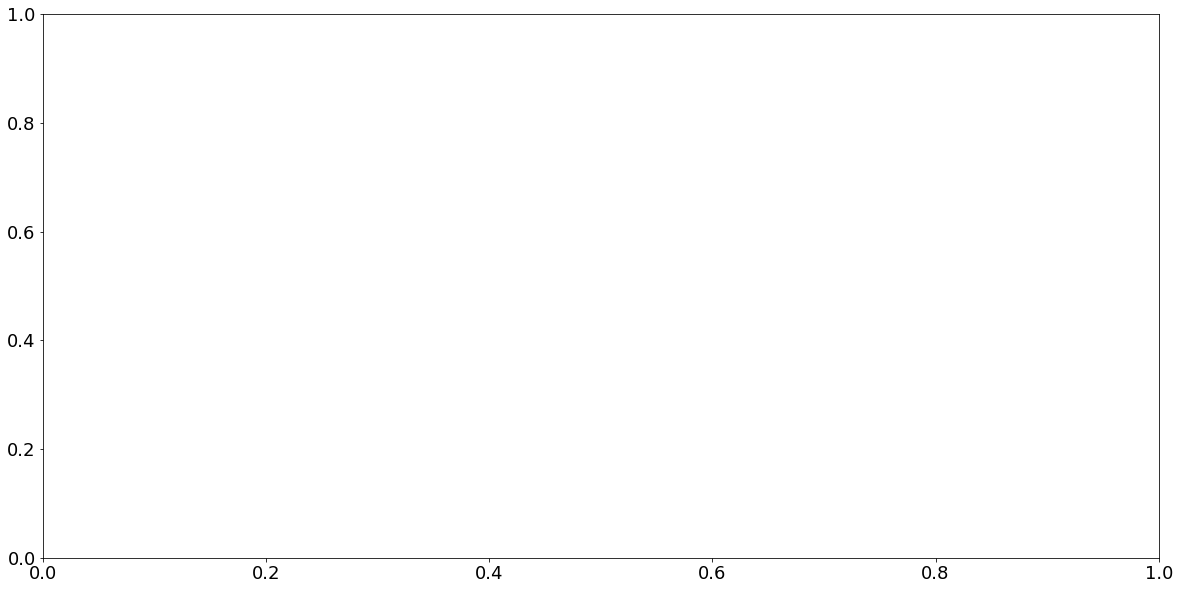

In [2]:
from scipy.stats import laplace, lognorm, norm

fig, ax = plt.subplots(figsize=(20, 10))
sns.distplot(profits, ax=ax, kde=False, norm_hist=True, bins=np.arange(-8, 8, 0.5), label='Samples')

mx = int(max(max(profits), abs(min(profits)))) + 1.5

x = np.linspace(-mx, mx, 2000)
ax.plot(x, laplace.pdf(x, laplace.fit(profits)[0], laplace.fit(profits)[1]), lw=2, color='black', label='Laplace')
# Lognorm matches up with normal almost exactly
#ax.plot(x, lognorm.pdf(x/100 + 1, lognorm.fit(profits/100 + 1)[0], lognorm.fit(profits/100 + 1)[1], 
#                       lognorm.fit(profits/100 + 1)[2])/100, lw=2, color='red', label='Lognorm')
ax.plot(x, norm.pdf(x, norm.fit(profits)[0], norm.fit(profits)[1]), lw=2, color='blue', label='Normal')

plt.legend(frameon=False, fontsize=MED)
sns.despine()
ax.get_yaxis().set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim(-mx, mx)
plt.show()